# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
05/06/2016 08:31:29  05/07/2016 08:31:29  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 05/06/2016 08:31:29


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-05-06 12:54 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-05-06 12:23 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-04-27 13:07 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [4]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf()

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "100")
#sconf.set("spark.executor.memory", "20g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", "Ready!")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code


# Reading the conf file

In [5]:
import json
import copy
execfile('../spark-scripts/conventions.py')

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'SenzaRipetizioni_1'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = None
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = BASE_PATH
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['name'] = 'ClusterBase'
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#



# Load data 

In [6]:
import subprocess
cmd =  "hdfs dfs -ls mattia/clusters"
result = subprocess.check_output(['bash','-c', cmd])
lines = result.split('\n')[1:-1]
clustersRDDs = []

for i in lines:
    CLUSTER_ALGO = i.split('/')[-1]
    clusterSongsFileRDD = sc.pickleFile(BASE_PATH + '/clusters/' + CLUSTER_ALGO)
    clustersRDDs.append((CLUSTER_ALGO, clusterSongsFileRDD))
    
    

# Compute some Stats

In [7]:
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  


font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

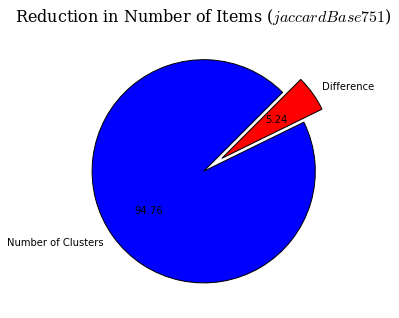

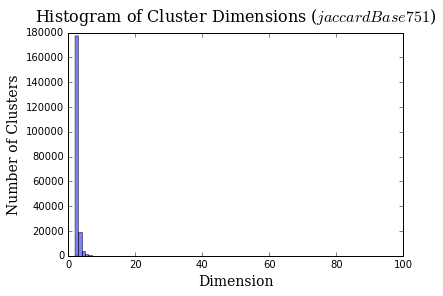

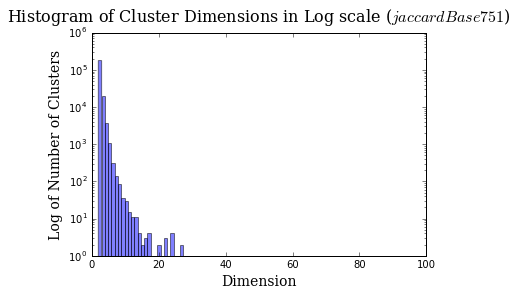

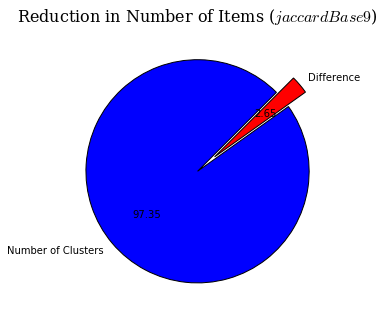

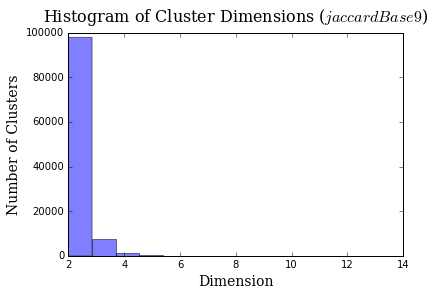

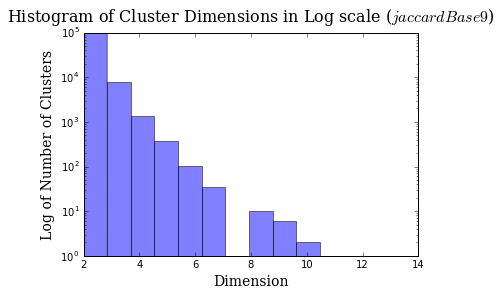

{'jaccardBase751': {'avg_len': 2.1706514326378525,
  'max_len': 92,
  'median_len': 2.0,
  'min_len': 2,
  'n_clusters': 202354,
  'total_n': 4282219},
 'jaccardBase9': {'avg_len': 2.1138395351435912,
  'max_len': 13,
  'median_len': 2.0,
  'min_len': 2,
  'n_clusters': 107388,
  'total_n': 4399492}}

In [15]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from math import *

%matplotlib inline

total_songs = 4519105

stats = {}

for i, cl in enumerate(clustersRDDs):
    clusterRDD = cl[1]
    name = cl[0]
    
    stats[name] = {}
    
    total_n = clusterRDD.count()
    stats[name]['total_n'] = total_n
    comparison_n = [total_n, (total_songs - total_n)]
    
    plt.figure(i+1, figsize = (10,5))
    plt.axes(aspect=1)    
    plt.pie(comparison_n, explode=[0, 0.2], labels=['Number of Clusters', 'Difference'], startangle = 45, autopct = '%.2f', \
           colors=('b', 'r', 'r', 'c', 'm', 'y', 'k', 'w')) 
    plt.title(r'Reduction in Number of Items ($' + name + '$)', fontdict = font_title)
    # Tweak spacing to prevent clipping of ylabel
    #plt.subplots_adjust(left=0.15)
    plt.show()
    
    
    clusterLens = clusterRDD.map(lambda x: len(x[1])).filter(lambda x: x>1).collect()
    
    n_clusters = len(clusterLens)
    stats[name]['n_clusters'] = n_clusters
    
    max_len = np.max(clusterLens)
    stats[name]['max_len'] = max_len
    
    min_len = np.min(clusterLens)
    stats[name]['min_len'] = min_len
    
    avg_len = np.mean(clusterLens)
    stats[name]['avg_len'] = avg_len
    
    median_len = np.median(clusterLens)
    stats[name]['median_len'] = median_len
    
    plt.hist(clusterLens, max_len, facecolor='blue', alpha=0.5)
    plt.xlabel('Dimension', fontdict = font_labels)
    plt.ylabel('Number of Clusters', fontdict = font_labels)
    plt.title(r'Histogram of Cluster Dimensions ($' + name + '$)', fontdict = font_title)
    plt.show()

    plt.hist(clusterLens, max_len, facecolor='blue', alpha=0.5, log = True)
    plt.xlabel('Dimension', fontdict = font_labels)
    plt.ylabel('Log of Number of Clusters', fontdict = font_labels)
    plt.title(r'Histogram of Cluster Dimensions in Log scale ($' + name + '$)', fontdict = font_title)

    # Tweak spacing to prevent clipping of ylabel
    plt.show()
    
    
    
stats